# Learn

In [1]:
import json
import os
from pathlib import Path
import sys
import time

import joblib
import numpy as np
import sklearn.ensemble
import sklearn.feature_selection
import sklearn.metrics
import sklearn.model_selection
from tqdm.auto import tqdm

root = str(Path.cwd().parents[1])
sys.path.append(root)
os.chdir(root)
import src

In [ ]:
X, y, s = src.get_Xys()
y = y>1
ys = y + 3*s

skf = sklearn.model_selection.StratifiedKFold(shuffle=True, random_state=42)
folds = list(skf.split(X=X, y=ys))

params = [
    (int(max_depth), n_bins)
    for max_depth in np.arange(1, 11)
    for n_bins in [2, 10]
]

cv = sklearn.model_selection.StratifiedKFold(shuffle=True, random_state=42)

pbar_orthogonality_ = tqdm(np.linspace(0, 1, 11), desc='orthogonality', 
                           position=0)
for orthogonality in pbar_orthogonality_:
    pbar_orthogonality_.set_postfix({'orthogonality': orthogonality})
    
    outer_splits_ = enumerate(cv.split(X=X, y=ys))
    pbar_outer_fold_ = tqdm(outer_splits_, total=5, leave=False, 
                            desc='outer_fold', position=1)
    for outer_fold, (trainval_indices, test_indices) in pbar_outer_fold_:
        X_trainval = X[trainval_indices]
        y_trainval = y[trainval_indices]
        s_trainval = s[trainval_indices]
        ys_trainval = ys[trainval_indices]
        X_test = X[test_indices]
        y_test = y[test_indices]
        s_test = s[test_indices]
    
        params_performance_ = []
        pbar_params_ = tqdm(enumerate(params), leave=False, total=len(params),
                            desc='params', position=2)
        for param_index, (max_depth, n_bins) in pbar_params_:
            assert isinstance(n_bins, int)
            assert isinstance(max_depth, int)
            params_ = {'max_depth': max_depth, 'n_bins': n_bins}
            pbar_params_.set_postfix(params_)
            param_performance_ = list()
            inner_splits_ = enumerate(cv.split(X=X_trainval, y=ys_trainval))
            pbar_inner_fold_ = tqdm(inner_splits_, total=5, leave=False, 
                                    position=3, desc='inner_fold')
            for inner_fold, (train_indices, val_indices) in pbar_inner_fold_:              
                filepath_ = f'cache/FRF_v3_A/Ai-{max_depth}-{orthogonality:.2f}-{n_bins}-{outer_fold}-{inner_fold}'
                if os.path.isfile(filepath_ + '.pkl'):
                    continue
                X_train = X_trainval[train_indices]
                y_train = y_trainval[train_indices]
                s_train = s_trainval[train_indices]
                X_val = X_trainval[val_indices]
                y_val = y_trainval[val_indices]
                s_val = s_trainval[val_indices]

                vt = sklearn.feature_selection.VarianceThreshold()
                vt.fit(X_train)
                X_train = vt.transform(X_train)
                X_val = vt.transform(X_val) 

                clf = src.FairRandomForestClassifier(
                    n_estimators=100, 
                    n_jobs=100, 
                    orthogonality=orthogonality,
                    **params_
                )
                start_fit = time.time()
                clf.fit(X_train, y_train, s_train)
                clf.fit_time = time.time() - start_fit #type: ignore
                joblib.dump(clf, filepath_ + '.pkl')           

# Predict

In [ ]:
import json
import os
import time

import joblib
import numpy as np
import pandas as pd
import sklearn.ensemble
import sklearn.feature_selection
import sklearn.metrics
import sklearn.model_selection
from tqdm.auto import tqdm

import src

X, y, s = src.get_Xys()
y = y > 1
ys = y + 3*s

skf = sklearn.model_selection.StratifiedKFold(shuffle=True, random_state=42)
folds = list(skf.split(X=X, y=ys))

params = [
    (int(max_depth), n_bins)
    for max_depth in np.arange(1, 11)
    for n_bins in [2]
]

cv = sklearn.model_selection.StratifiedKFold(shuffle=True, random_state=42)

pbar_orthogonality_ = tqdm(np.linspace(0, 1, 11), desc='orthogonality', 
                           position=0)
for orthogonality in pbar_orthogonality_:
    pbar_orthogonality_.set_postfix({'orthogonality': orthogonality})
    
    outer_splits_ = enumerate(cv.split(X=X, y=ys))
    pbar_outer_fold_ = tqdm(outer_splits_, total=5, leave=False, 
                            desc='outer_fold', position=1)
    for outer_fold, (trainval_indices, test_indices) in pbar_outer_fold_:
        X_trainval = X[trainval_indices]
        y_trainval = y[trainval_indices]
        s_trainval = s[trainval_indices]
        ys_trainval = ys[trainval_indices]
        X_test = X[test_indices]
        y_test = y[test_indices]
        s_test = s[test_indices]
    
        params_performance_ = []
        pbar_params_ = tqdm(enumerate(params), leave=False, total=len(params),
                            desc='params', position=2)
        for param_index, (max_depth, n_bins) in pbar_params_:
            assert isinstance(n_bins, int)
            assert isinstance(max_depth, int)
            params_ = {'max_depth': max_depth, 'n_bins': n_bins}
            pbar_params_.set_postfix(params_)
            param_performance_ = list()
            inner_splits_ = enumerate(cv.split(X=X_trainval, y=ys_trainval))
            pbar_inner_fold_ = tqdm(inner_splits_, total=5, leave=False, 
                                    position=3, desc='inner_fold')
            for inner_fold, (train_indices, val_indices) in pbar_inner_fold_:
                filepath_ = f'cache/FRF_v3_A/Ai-{max_depth}-{orthogonality:.2f}-{n_bins}-{outer_fold}-{inner_fold}'
                if os.path.isfile(filepath_ + '.npy'):
                    continue
                X_train = X_trainval[train_indices]
                X_val = X_trainval[val_indices]
                
                vt = sklearn.feature_selection.VarianceThreshold()
                vt.fit(X_train)
                X_train = vt.transform(X_train)
                X_val = vt.transform(X_val)                 
                
                assert os.path.isfile(filepath_ + '.pkl')
                clf = joblib.load(filepath_ + '.pkl')
                y_score = clf.predict_proba(X_val)[:,1] #type: ignore
                np.save(filepath_ + '.npy', y_score)

# Measure

In [ ]:
import json
import os
import time

import joblib
import numpy as np
import pandas as pd
import sklearn.ensemble
import sklearn.feature_selection
import sklearn.metrics
import sklearn.model_selection
from tqdm.auto import tqdm

import src

X, y, s = src.get_Xys()
y = y > 1
ys = y + 3*s

skf = sklearn.model_selection.StratifiedKFold(shuffle=True, random_state=42)
folds = list(skf.split(X=X, y=ys))

params = [
    (int(max_depth), n_bins)
    for max_depth in np.arange(1, 11)
    for n_bins in [2]
]

cv = sklearn.model_selection.StratifiedKFold(shuffle=True, random_state=42)

result = list()

pbar_ortho_ = tqdm(np.linspace(0, 1, 11), desc='orthogonality', position=0)
for ortho in pbar_ortho_:
    pbar_ortho_.set_postfix({'orthogonality': ortho})
    
    outer_splits_ = enumerate(cv.split(X=X, y=ys))
    pbar_outer_fold_ = tqdm(outer_splits_, total=5, leave=False, 
                            desc='outer_fold', position=1)
    for outer_fold, (trainval_indices, _) in pbar_outer_fold_:
        y_trainval, ys_trainval = y[trainval_indices], ys[trainval_indices]
    
        params_performance_ = list()
        pbar_params_ = tqdm(params, leave=False, total=len(params),
                            desc='params', position=2)
        for max_depth, n_bins in pbar_params_:
            assert isinstance(n_bins, int)
            assert isinstance(max_depth, int)
            params_ = {'max_depth': max_depth, 'n_bins': n_bins}
            pbar_params_.set_postfix(params_)
            param_performance_ = list()
            inner_splits_ = enumerate(cv.split(X=y_trainval, y=ys_trainval))
            pbar_inner_fold_ = tqdm(inner_splits_, total=5, leave=False, 
                                    position=3, desc='inner_fold')
            for inner_fold, (_, val_indices) in pbar_inner_fold_:
                filepath_ = f'cache/FRF_v3_A/Ai-{max_depth}-{ortho:.2f}-{n_bins}-{outer_fold}-{inner_fold}'
                assert os.path.isfile(filepath_ + '.npy')
                y_val = y_trainval[val_indices]    
                y_score = np.load(filepath_ + '.npy')          
                auc_y = sklearn.metrics.roc_auc_score(y_val, y_score)
                param_performance_.append(auc_y)
            params_performance_.append(np.mean(param_performance_))
        
        max_depth, n_bins = params[np.argmax(params_performance_)]
        filepath = f'cache/FRF_v3_A/Ao-{max_depth}-{ortho:.1f}-{outer_fold}-{n_bins}'
        assert os.path.isfile(filepath + '.json')
        with open(filepath + '.json') as file:
            result.append(json.load(file))
with open("cache/FRF_v3_A_nested.json", 'w') as file:
    json.dump(result, file)
        

In [4]:
import pandas as pd
pd.read_json('cache/FRF_v3_A_non-nested.json')

,fold,max_depth,orthogonality,n_bins,auc_y,auc_s,threshold,proportion_predicted_ok_white,proportion_predicted_ok_black,disparate_impact,disparate_impact_epsilon,false_ok_white,false_ok_black,true_ok_white,true_ok_black,equalized_odds_false_ok,equalized_odds_true_ok,equalized_odds_epsilon
0,0,1,0.0,2,0.614636,0.662896,0.073694,0.948258,0.869565,0.917013,0.082987,0.932367,0.771084,0.948975,0.903766,0.161283,0.045209,0.161283
1,1,1,0.0,2,0.635834,0.664459,0.071014,0.950125,0.842105,0.886310,0.113690,0.932367,0.746988,0.950927,0.875000,0.185379,0.075927,0.185379
2,2,1,0.0,2,0.636815,0.664311,0.071136,0.950125,0.839009,0.883051,0.116949,0.913043,0.726190,0.951799,0.878661,0.186853,0.073138,0.186853
3,3,1,0.0,2,0.634249,0.655664,0.070335,0.946369,0.873065,0.922542,0.077458,0.884058,0.761905,0.949182,0.912134,0.122153,0.037048,0.122153
4,4,1,0.0,2,0.633381,0.637530,0.071115,0.948247,0.850932,0.897373,0.102627,0.874396,0.746988,0.951581,0.887029,0.127408,0.064552,0.127408
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,0,10,1.0,10,0.500000,0.500000,0.788028,0.000000,0.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1096,1,10,1.0,10,0.500000,0.500000,0.788104,0.000000,0.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1097,2,10,1.0,10,0.500000,0.500000,0.788275,0.000000,0.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1098,3,10,1.0,10,0.500000,0.500000,0.787837,0.000000,0.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.model_selection

import src

data = (
    pd.read_json("cache/FRF_v3_A_nested.json")
    .groupby(['max_depth', 'orthogonality', 'n_bins'])
    .mean()
    .reset_index()
    .sort_values('auc_y', ascending=False)
    .drop_duplicates(subset=['orthogonality'])
    .sort_values('orthogonality')
)
data

X, y, s = src.get_Xys()
y = y<2
title_prefix = f'Fair Random Forest (nested gridsearch) | Scenario A\nmax_depth=[1-10] | n_estimators=100 | n_bins=2'
base_rate = np.mean(y)
base_rate_black = np.mean(y[s])
base_rate_white = np.mean(y[~s])

In [3]:
pd.read_json("cache/FRF_v3_A_nested.json")

,fold,max_depth,orthogonality,n_bins,auc_y,auc_s,threshold,proportion_predicted_ok_white,proportion_predicted_ok_black,disparate_impact,disparate_impact_epsilon,false_ok_white,false_ok_black,true_ok_white,true_ok_black,equalized_odds_false_ok,equalized_odds_true_ok,equalized_odds_epsilon
0,0,5,0.0,2,0.650049,0.676881,0.107144,0.953057,0.798137,0.837449,0.162551,0.898551,0.662651,0.955517,0.845188,0.235900,0.110329,0.235900
1,1,5,0.0,2,0.680731,0.656809,0.105836,0.953255,0.795666,0.834683,0.165317,0.869565,0.638554,0.957034,0.850000,0.231011,0.107034,0.231011
2,2,5,0.0,2,0.670023,0.668781,0.107857,0.951586,0.817337,0.858921,0.141079,0.869565,0.666667,0.955289,0.870293,0.202899,0.084996,0.202899
3,3,5,0.0,2,0.675920,0.658689,0.112153,0.951586,0.817337,0.858921,0.141079,0.859903,0.678571,0.955725,0.866109,0.181332,0.089616,0.181332
4,4,5,0.0,2,0.674480,0.643574,0.110525,0.952629,0.804348,0.844345,0.155655,0.821256,0.710843,0.958561,0.836820,0.110413,0.121740,0.121740
5,0,5,0.1,2,0.645563,0.668285,0.106904,0.953682,0.788820,0.827131,0.172869,0.903382,0.650602,0.955953,0.836820,0.252779,0.119133,0.252779
6,1,5,0.1,2,0.682864,0.651179,0.104480,0.953255,0.795666,0.834683,0.165317,0.874396,0.626506,0.956816,0.854167,0.247890,0.102649,0.247890
7,2,5,0.1,2,0.671489,0.663264,0.110773,0.952003,0.811146,0.852041,0.147959,0.874396,0.678571,0.955507,0.857741,0.195825,0.097767,0.195825
8,3,5,0.1,2,0.676477,0.655467,0.106726,0.951795,0.814241,0.855480,0.144520,0.855072,0.666667,0.956161,0.866109,0.188406,0.090053,0.188406
9,4,5,0.1,2,0.679598,0.639099,0.109864,0.951795,0.816770,0.858137,0.141863,0.821256,0.710843,0.957688,0.853556,0.110413,0.104132,0.110413


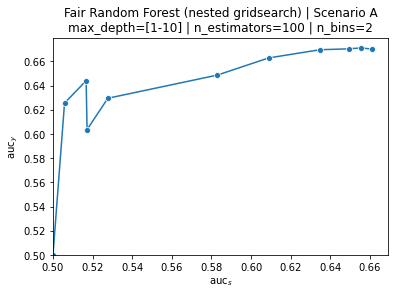

In [3]:
sns.lineplot(data=data, x='auc_s', y='auc_y', marker='o')
plt.xlim(.5)
plt.ylim(.5)
plt.xlabel(r'$\mathrm{auc}_s$')
plt.ylabel(r'$\mathrm{auc}_y$')
plt.title(title_prefix);

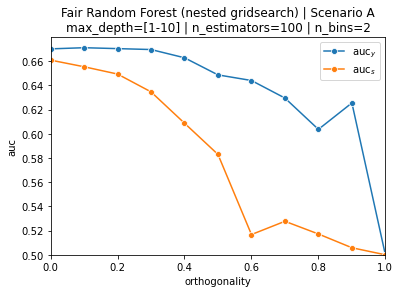

In [4]:
sns.lineplot(data=data, x='orthogonality', y='auc_y', label=r'$\mathrm{auc}_y$', marker='o')
sns.lineplot(data=data, x='orthogonality', y='auc_s', color='C1', label=r'$\mathrm{auc}_s$', marker='o')
plt.xlim(0, 1)
plt.ylim(.5)
plt.xlabel('orthogonality')
plt.ylabel('auc')
plt.title(title_prefix);

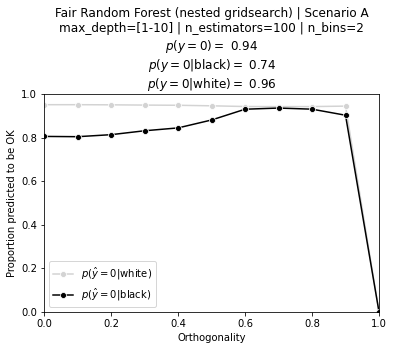

In [5]:
sns.lineplot(data=data, x='orthogonality', y='proportion_predicted_ok_white', color='lightgrey', label=r'$p(\haty=0|\mathrm{white})$', marker='o')
sns.lineplot(data=data, x='orthogonality', y='proportion_predicted_ok_black', color='black', label=r'$p(\haty=0|\mathrm{black})$', marker='o')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('Orthogonality')
plt.ylabel('Proportion predicted to be OK')
title_first_line = 'Fair Random Forest (non-nested gridsearch) | Scenario A'
title_second_line = 'max_depth=[1-10] | n_estimators=100 | n_bins=2'
title_third_line = f'$p(y=0)=$ {base_rate:.2f}'
title_fourth_line = f'$p(y=0|\mathrm{{black}})=$ {base_rate_black:.2f}'
title_fifth_line = f'$p(y=0|\mathrm{{white}})=$ {base_rate_white:.2f}'
plt.title(title_prefix + '\n' + title_third_line + '\n' + title_fourth_line + '\n' + title_fifth_line);

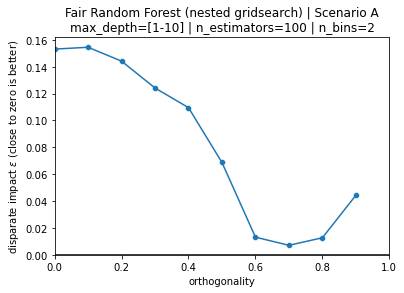

In [6]:
sns.lineplot(data=data, x='orthogonality', y='disparate_impact_epsilon')
sns.scatterplot(data=data, x='orthogonality', y='disparate_impact_epsilon')
plt.xlim(0, 1)
plt.ylim(0)
plt.xlabel('orthogonality')
plt.axhline(0, ls='-', color='black')
plt.ylabel(r'disparate impact $\epsilon$ (close to zero is better)')
plt.title(title_prefix);

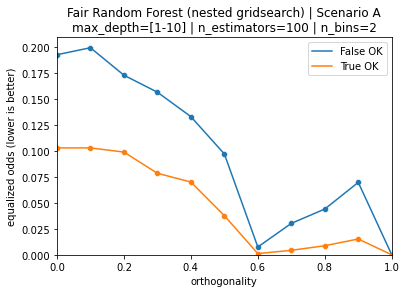

In [7]:
sns.lineplot(data=data, x='orthogonality', y='equalized_odds_false_ok', label='False OK')
sns.lineplot(data=data, x='orthogonality', y='equalized_odds_true_ok', label='True OK', color='C1')
sns.scatterplot(data=data, x='orthogonality', y='equalized_odds_false_ok')
sns.scatterplot(data=data, x='orthogonality', y='equalized_odds_true_ok', color='C1')
plt.xlim(0, 1)
plt.ylim(0)
plt.xlabel('orthogonality')
plt.ylabel(r'equalized odds (lower is better)')
plt.title(title_prefix);

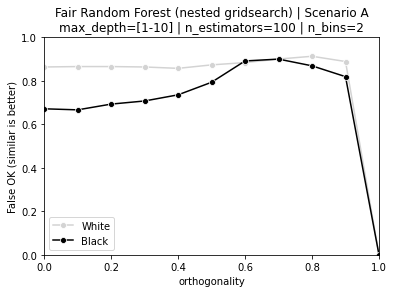

In [8]:
sns.lineplot(data=data, x='orthogonality', y='false_ok_white', label='White', marker='o', color='lightgrey')
sns.lineplot(data=data, x='orthogonality', y='false_ok_black', label='Black', marker='o', color='black')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('orthogonality')
plt.ylabel(r'False OK (similar is better)')
plt.title(title_prefix);

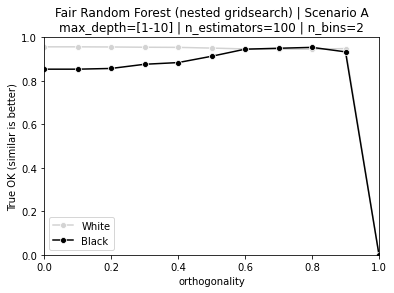

In [9]:
sns.lineplot(data=data, x='orthogonality', y='true_ok_white', label='White', marker='o', color='lightgrey')
sns.lineplot(data=data, x='orthogonality', y='true_ok_black', label='Black', marker='o', color='black')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('orthogonality')
plt.ylabel(r'True OK (similar is better)')
plt.title(title_prefix);